# Transfer Learning to predict Sign Language images

### Your own image classification system
- Create an image classification system using a variety of sign Language images, rather than relying solely on the pre-existing sample data provided by Tensorflow.
- Finding the right model training when you don't have enough training data to achieve adequate production performance due to many constraints in the data collection process.
- Check the process of learning with a limited amount of data using an already trained learning model.

## Setup

Import TensorFlow and other necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

import keras
from keras.models import Sequential

## Data preprocessing

### Data downLoad and prepare (Google Drive Mount)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import shutil

shutil.copy('/content/gdrive/MyDrive/Colab Notebooks/CV_sign_language_filterted/sign_language_filtered.zip', '/content/')

'/content/sign_language_filtered.zip'

In [4]:
# It will delete existing generated files on repeated runs.
#반복적인 실행시 기존의 생성된 파일을 삭제해 줍니다.
root_dir = '/content'

import os

if os.path.exists(os.path.join(root_dir, 'sign_language_filtered')):
    shutil.rmtree(os.path.join(root_dir, 'sign_language_filtered'))

In [5]:
# Import the compressed file module.
# 압축파일 모듈 import해 줍니다.
import zipfile

# Use the Python with function to make the sign_language_filtered.zip file accessible as target_file.
# 파이썬 with함수를 사용해서 sign_language_filtered.zip 파일을 target_file으로 접근하게 만듭니다.
with zipfile.ZipFile(os.path.join(root_dir, 'sign_language_filtered.zip'), mode='r') as target_file: # mode='r' (읽기 모드)

  target_file.extractall(os.path.join(root_dir, 'sign_language_filtered')) # Unzip the zip file to that path.(해당 경로에 zip파일을 해제)

In [6]:
# Convert HEIC files to jpegs
# HEIC파일을 jpeg파일로 변환

!pip install pyheif
!pip install Pillow

# import os(처음에 지정해줌)
import pyheif
from PIL import Image

root_dir = '/content'
dataset_class = ['train','test']

for dataset_name in dataset_class:
  folder_path = os.path.join(root_dir, 'sign_language_filtered', dataset_name)
  for label in range(1, 11):
    class_folder = os.path.join(folder_path, str(label))
    for filename in os.listdir(class_folder):
        if filename.lower().endswith(".heic"):
           input_path = os.path.join(class_folder, filename)
           output_path = os.path.join(class_folder, f"{os.path.splitext(filename)[0]}.jpeg")

           heif_file = pyheif.read(input_path)
           image = Image.frombytes(
              heif_file.mode,
              heif_file.size,
              heif_file.data,
              "raw"
           )
           image.save(output_path, "jpeg")
           os.remove(input_path) #기존 HEIC파일 제거

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 58.1 MB/s eta 0:00:00


Checking data quantity after download completion

* Train images are 777

    (Since there are few train images, we use the previously trained model for learning - Transfer learning)
* 330 test images

There are 1107 images in total.

In [ ]:
train_dir = os.path.join(root_dir, 'sign_language_filtered/train/')
test_dir = os.path.join(root_dir, 'sign_language_filtered/test/')

In [ ]:
import pathlib
from pathlib import Path

train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)

# 훈련용데이터셋 과 테스트용데이터셋의 이미지수량을 확인한다.
train_image_count = len(list(train_dir.glob('*/*.*'))) #glob는 문자열 객체에서 호출할수 없다. 그래서 pathlib.path를 사용
test_image_count = len(list(test_dir.glob('*/*.*')))   #왜 */*으로 가운데 '/'가 들어가는지 확인하기

print(train_image_count)
print(test_image_count)
total = int(train_image_count) + int(test_image_count)
print(total)

777
330
1107


### Create a dataset

Define some parameters for the loader:

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

Since we don't have a validation dataset, we use 80% of the images for training and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 777 files belonging to 10 classes.
Using 622 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 777 files belonging to 10 classes.
Using 155 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  validation_split=None,
  subset=None,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 330 files belonging to 10 classes.


### Visualize the data

Output the first 10 images from the training dataset

You can find the class names in the `class_names` attribute of these datasets.

['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


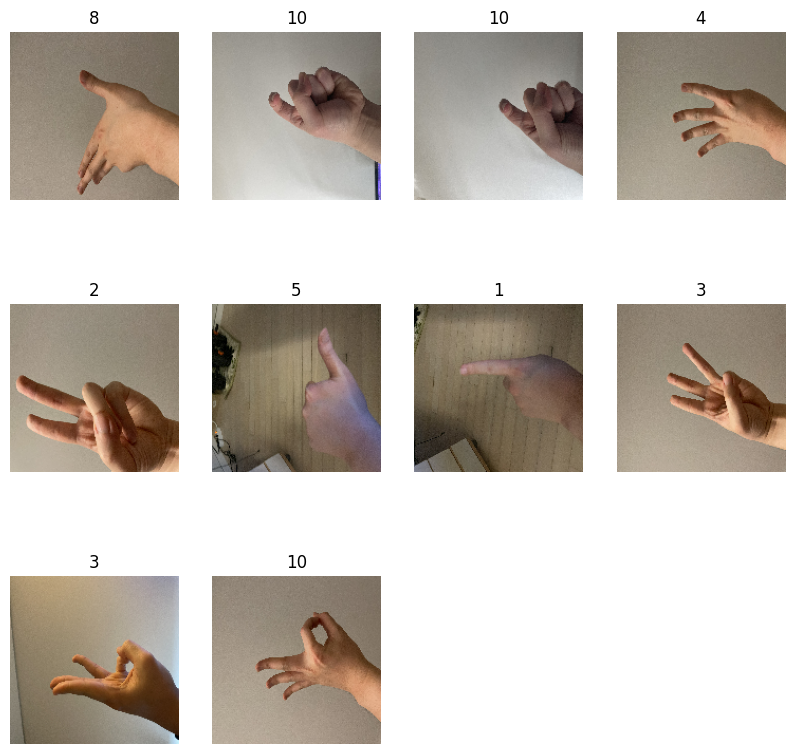

In [ ]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(0,10): # 0부터 10직전까지 (0~9)
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds: # tf.keras.utils.image_dataset_from_directory으로 데이터 셋을 만들때 batch사이즈를 정해 주었다.
  print(image_batch.shape)                 # (32, 160, 160, 3)의 의미
  print(labels_batch.shape)                # 32: 한번에 처리되는 이미지의 개수(배치크기)/32개의 이미지를 묶어 주었다는 의미미
  break                                    # 160,160: 이미지의 높이와 너비를 의미
                                           # 3: 이미지의 채널 수를 의미. 컬러 이미지는 3(R,G,B)

(32, 160, 160, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 160, 160, 3)` with 32 images of the shape `160x160x3` (the last dimension represents the color channel RGB). The `label_batch` is a tensor of the shape `(32,)`, with labels corresponding to the 32 images.

### Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

In [ ]:
# Data Augmenation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

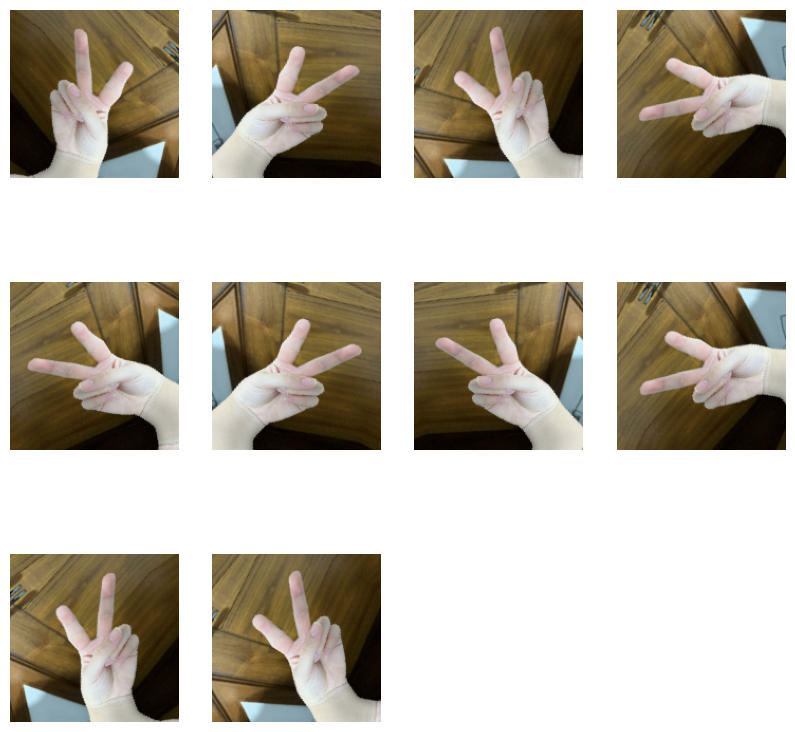

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(10): # 0부터 10직전까지 (0~9)
    ax = plt.subplot(3, 4, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create a base model from a pre-trained convolutional network

Create a pre-trained base model on the ImageNet dataset using the MobileNet V2 model. Select the bottleneck layer to use for feature extraction, and use `include_top = False` to load the network excluding the classification layer.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, # 새롭게 학습시킬 이미지 텐서 크기
                                               include_top=False,     # 사전학습 모델의 특징 추출기만 가져옴/True일때,사전학습 모델의 특징추출기와 분류기 모두 가져옴
                                               weights='imagenet')    # 사전학습에 사용된 데이터셋

9406464/9406464 [==============================] - 1s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features.

In [ ]:
image_batch, label_batch = next(iter(train_ds)) # iter를 사용하여 train_ds에서 이미지 배치를 가지고 옴
feature_batch = base_model(image_batch)         # next(iter(train_ds))를 사용하여 첫번째 이미지 배치를 선택
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(10, activation='softmax') # activation함수를 지정해 주지 않으면 relu함수를 사용하게 됨.
prediction_batch = prediction_layer(feature_batch_average)         # 지금 처럼 클래스가 많은 다중 클래스 분류 모델을 만들때는 softmax함수를 사용해야 한다.
print(prediction_batch.shape)

(32, 10)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # BinaryCrossentropy -> SparseCategoricalCrossentropy 수정해 줘야 한다.
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

### Train the model

After training for 100 epochs, you should see ~73% accuracy on the validation set.


In [ ]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(val_ds)

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 [==============================] - 10s 130ms/step - loss: 2.7684 - accuracy: 0.1548


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.77
initial accuracy: 0.15


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/100
20/20 [==============================] - 35s 847ms/step - loss: 2.8241 - accuracy: 0.1206 - val_loss: 2.5824 - val_accuracy: 0.1419
Epoch 2/100
20/20 [==============================] - 1s 29ms/step - loss: 2.6731 - accuracy: 0.1399 - val_loss: 2.4744 - val_accuracy: 0.1677
Epoch 3/100
20/20 [==============================] - 1s 35ms/step - loss: 2.5442 - accuracy: 0.1431 - val_loss: 2.4099 - val_accuracy: 0.1742
Epoch 4/100
20/20 [==============================] - 1s 31ms/step - loss: 2.4564 - accuracy: 0.1752 - val_loss: 2.3508 - val_accuracy: 0.2000
Epoch 5/100
20/20 [==============================] - 1s 29ms/step - loss: 2.3715 - accuracy: 0.1929 - val_loss: 2.3054 - val_accuracy: 0.2065
Epoch 6/100
20/20 [==============================] - 1s 29ms/step - loss: 2.3385 - accuracy: 0.2042 - val_loss: 2.2629 - val_accuracy: 0.2000
Epoch 7/100
20/20 [==============================] - 1s 29ms/step - loss: 2.1887 - accuracy: 0.2492 - val_loss: 2.2249 - val_accuracy: 0.2065
Epoc

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor.

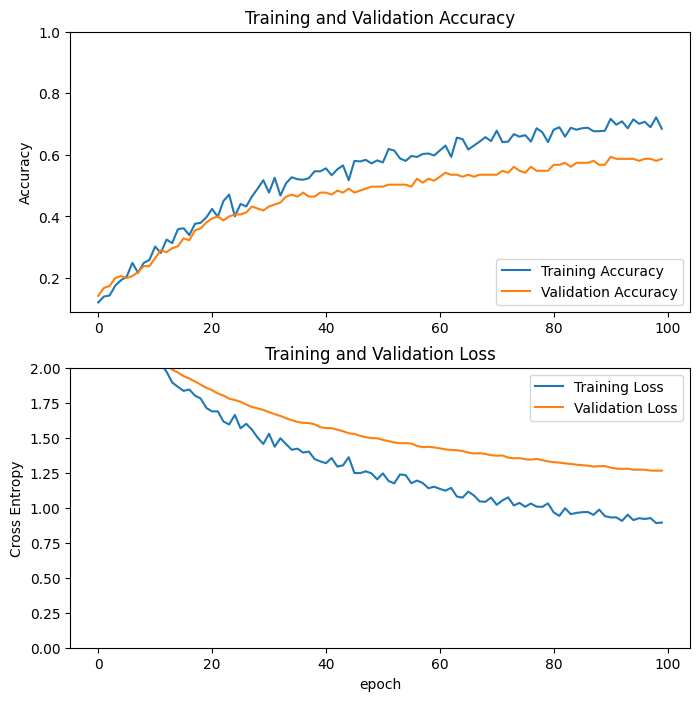

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


## Compile the model

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

56

### Continue training the model

If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

In [ ]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 100/200
20/20 [==============================] - 14s 100ms/step - loss: 0.8880 - accuracy: 0.6977 - val_loss: 1.1586 - val_accuracy: 0.5806
Epoch 101/200
20/20 [==============================] - 1s 41ms/step - loss: 0.8145 - accuracy: 0.7251 - val_loss: 1.1369 - val_accuracy: 0.6000
Epoch 102/200
20/20 [==============================] - 1s 41ms/step - loss: 0.7333 - accuracy: 0.7283 - val_loss: 1.0634 - val_accuracy: 0.6129
Epoch 103/200
20/20 [==============================] - 1s 41ms/step - loss: 0.7634 - accuracy: 0.7412 - val_loss: 1.0271 - val_accuracy: 0.6323
Epoch 104/200
20/20 [==============================] - 1s 44ms/step - loss: 0.7035 - accuracy: 0.7492 - val_loss: 1.0116 - val_accuracy: 0.6323
Epoch 105/200
20/20 [==============================] - 1s 47ms/step - loss: 0.6796 - accuracy: 0.7572 - val_loss: 0.9553 - val_accuracy: 0.6710
Epoch 106/200
20/20 [==============================] - 1s 46ms/step - loss: 0.6016 - accuracy: 0.7942 - val_loss: 0.9726 - val_accurac

Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.



After fine tuning the model nearly reaches 98% accuracy on the validation set.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

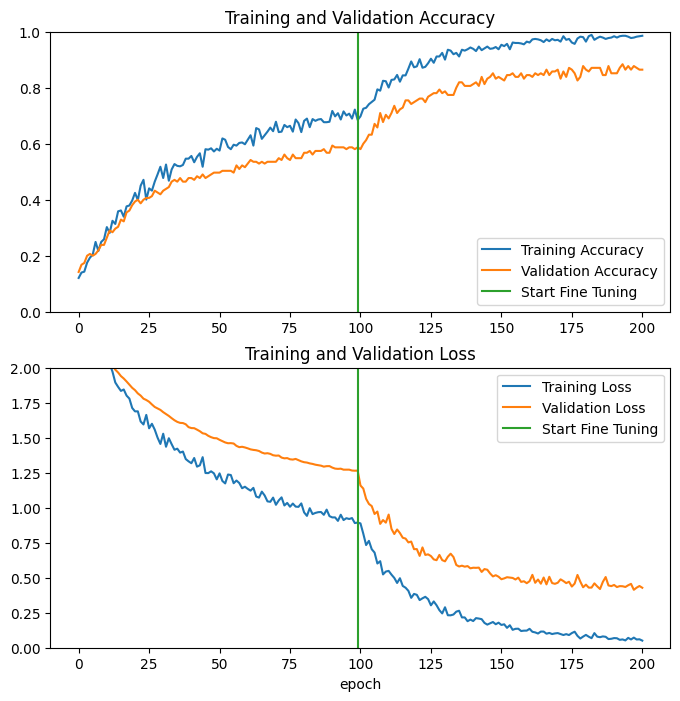

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finally you can verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

11/11 [==============================] - 18s 214ms/step - loss: 2.4308 - accuracy: 0.4909
Test accuracy : 0.4909090995788574


Now we can use this model to predict the number based on the shape of the hand.

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [2 8 8 9 1 3 1 6 1 0 0 0 4 2 0 9 8 0 8 5 3 3 4 9 2 2 9 1 7 4 8 4]


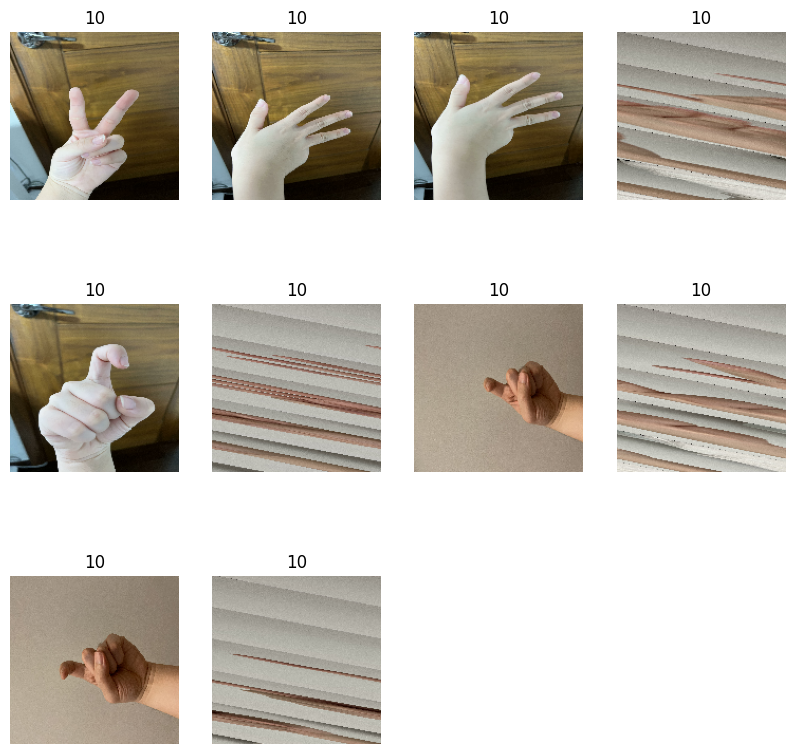

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(10):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* When dealing with a small dataset, it is common to make use of a pre-trained model that has learned features on a larger dataset in the same domain. This involves adding a fully-connected classifier on top of the pre-trained model, with only the weights of the classifier being updated during training. The convolutional base of the pre-trained model extracts all the features associated with each image, and the classifier determines the image class based on the set of extracted features.

* To further enhance performance, it is recommended to fine-tune the top-level layers of the pre-trained model to the new dataset. This involves adjusting the model's weights to learn high-level features specific to the dataset. This technique is typically suggested when the training dataset is large and very similar to the original dataset on which the pre-trained model was trained.



## Challenges:

- When building the dataset, I spent a lot of time obsessing about making it a Numpy array.
In the end, it was okay to go with TF data instead of overlapping arrays.

- The number of train data was significantly smaller and I was obsessed with agumnetizing it to increase it.
So I tried to make the data look like (60000, 160, 160, 160, 3).

  What does (60000, 160, 160, 3) mean?
  60000: number of images processed at once.  
  (batch size) / 60000 images batched together
  60000 images together
  160: Height of the image
  160: the width of the image
  3: Number of channels in the image.
     Color images are 3(R,G,B)

  The reason for using Transger Learing is that we realized that with such a small dataset, we can proceed with machine learning with a pre-trained model.

- BinaryCrossentropy -> SparseCategoricalCrossentropy should be modified.
  Since I didn't find this part, I kept getting only 20% to 30% learning rate.
  I was shocked that this was all I got, even with Transger learning.

- The output nodes of the last Out layer should be modified to 10, and the activation function should be Relu for dual classification like dog and cat image classification, but softmax is appropriate for multi-class classification. It was difficult to figure out how to change this to softmax, and as soon as I did, the learning rate was over 95%.

- It seems that the accuracy is over 95% only when epoch is set to 100. Personally, I suspect that the learning model is not appropriate.